# Getting Started with PyFixest

## What is a fix effect model?

A fixed effect model is a statistical model that includes fixed effects, which are parameters that are estimated to be constant across different groups. 

**Example [Panel Data]:** In the context of panel data, fixed effects are parameters that are constant across different individuals or time. The typical model example is given by the following equation:

$$
Y_{it} = \beta X_{it} + \alpha_i + \psi_t + \varepsilon_{it}
$$

where $Y_{it}$ is the dependent variable for individual $i$ at time $t$, $X_{it}$ is the independent variable, $\beta$ is the coefficient of the independent variable, $\alpha_i$ is the individual fixed effect, $\psi_t$ is the time fixed effect, and $\varepsilon_{it}$ is the error term. The individual fixed effect $\alpha_i$ is a parameter that is constant across time for each individual, while the time fixed effect $\psi_t$ is a parameter that is constant across individuals for each time period.

Note however that, despite the fact that fixed effects are commonly used in panel setting, one does not need a panel data set to work with fixed effects. For example, cluster randomized trials with cluster fixed effects, or wage regressions with worker and firm fixed effects.

In this "quick start" guide, we will show you how to estimate a fixed effect model using the `PyFixest` package. We do not go into the details of the theory behind fixed effect models, but we focus on how to estimate them using `PyFixest`.

## Read Sample Data

In a first step, we load the module and some synthetic example data:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from lets_plot import LetsPlot

import pyfixest as pf
from pyfixest.did.estimation import did2s
from pyfixest.did.event_study import event_study

LetsPlot.setup_html()

plt.style.use("seaborn-v0_8")

%load_ext autoreload
%autoreload 2
%load_ext watermark
%config InlineBackend.figure_format = "retina"
%watermark --iversions

matplotlib: 3.8.4
pandas    : 2.2.2
pyfixest  : 0.20.0



In [2]:
data = pf.get_data()

data.head()

,Y,Y2,X1,X2,f1,f2,f3,group_id,Z1,Z2,weights
0,NaN,2.357103,0.0,0.457858,15.0,0.0,7.0,9.0,-0.330607,1.054826,0.661478
1,-1.458643,5.163147,NaN,-4.998406,6.0,21.0,4.0,8.0,NaN,-4.113690,0.772732
2,0.169132,0.751140,2.0,1.558480,NaN,1.0,7.0,16.0,1.207778,0.465282,0.990929
3,3.319513,-2.656368,1.0,1.560402,1.0,10.0,11.0,3.0,2.869997,0.467570,0.021123
4,0.134420,-1.866416,2.0,-3.472232,19.0,20.0,6.0,14.0,0.835819,-3.115669,0.790815


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Y         999 non-null    float64
 1   Y2        1000 non-null   float64
 2   X1        999 non-null    float64
 3   X2        1000 non-null   float64
 4   f1        999 non-null    float64
 5   f2        1000 non-null   float64
 6   f3        1000 non-null   float64
 7   group_id  1000 non-null   float64
 8   Z1        999 non-null    float64
 9   Z2        1000 non-null   float64
 10  weights   1000 non-null   float64
dtypes: float64(11)
memory usage: 86.1 KB


We see that some of our columns have missing data.

## OLS Estimation

We are interested in the relation between the dependent variable `Y` and the independent variables `X1` using a fixed effect model for `group_id`. Let's see how the data looks like:

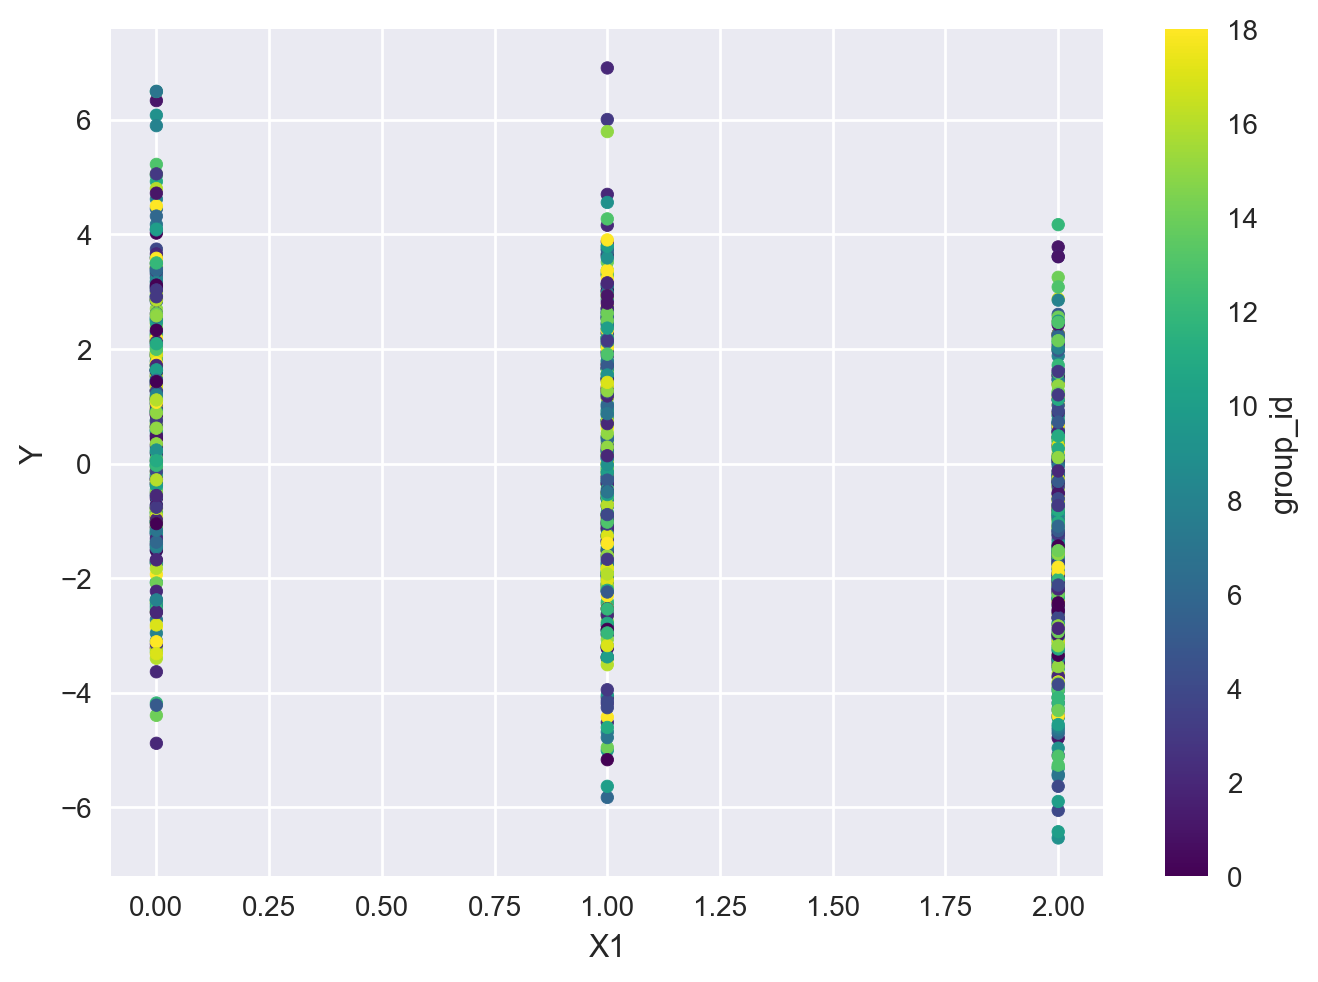

In [4]:
ax = data.plot(kind="scatter", x="X1", y="Y", c="group_id", colormap="viridis")

We can estimate a fixed effects regression via the `feols()` function. `feols()` has three arguments: a two-sided model formula, the data, and optionally, the type of inference.

In [5]:
fit = pf.feols(fml="Y ~ X1 | group_id", data=data, vcov="HC1")
type(fit)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


pyfixest.estimation.feols_.Feols

The first part of the formula contains the dependent variable and "regular" covariates, while the second part contains fixed effects.

`feols()` returns an instance of the `Fixest` class.

To inspect the results, we can use a summary function or method:

In [6]:
fit.summary()

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: group_id
Inference:  HC1
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |     -1.019 |        0.082 |   -12.352 |      0.000 | -1.181 |  -0.857 |
---
RMSE: 2.141 R2: 0.137 R2 Within: 0.126 


Alternatively, the `.summarize` module contains a `summary` function, which can be applied on instances of regression model objects 
or lists of regression model objects. 

In [7]:
pf.summary(fit)

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: group_id
Inference:  HC1
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |     -1.019 |        0.082 |   -12.352 |      0.000 | -1.181 |  -0.857 |
---
RMSE: 2.141 R2: 0.137 R2 Within: 0.126 


You can access individual elements of the summary via dedicated methods: `.tidy()` returns a "tidy" `pd.DataFrame`, 
`.coef()` returns estimated parameters, and `se()` estimated standard errors. Other methods include `pvalue()`, `confint()`
and `tstat()`.

In [8]:
fit.coef()

Coefficient
X1   -1.019009
Name: Estimate, dtype: float64

In [9]:
fit.se()

Coefficient
X1    0.082498
Name: Std. Error, dtype: float64

## How to interpret the results?

Let's have a quick d-tour on the intuition behind fixed effects models using the example above. To do so, let us begin by comparing it with a simple OLS model.

In [10]:
fit_simple = pf.feols("Y ~ X1", data=data, vcov="HC1")

fit_simple.summary()

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: 
Inference:  HC1
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      0.919 |        0.112 |     8.223 |      0.000 |  0.699 |   1.138 |
| X1            |     -1.000 |        0.082 |   -12.134 |      0.000 | -1.162 |  -0.838 |
---
RMSE: 2.158 R2: 0.123 


We see that the `X1` coefficient is `-1.0`, which is less than the value from the OLS model above (which was `0.949`). Where is the difference coming from?
Well, in the fixed effect model we are interested in controlling for the feature `f1`. One possibility to do this is by adding a simple dummy variable for each level of `f1`.

In [11]:
fit_dummy = pf.feols("Y ~ X1 + C(group_id) ", data=data, vcov="HC1")

fit_dummy.summary()

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: 
Inference:  HC1
Observations:  998

| Coefficient         |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept           |      0.760 |        0.288 |     2.640 |      0.008 |  0.195 |   1.326 |
| X1                  |     -1.019 |        0.083 |   -12.234 |      0.000 | -1.182 |  -0.856 |
| C(group_id)[T.1.0]  |      0.380 |        0.451 |     0.844 |      0.399 | -0.504 |   1.264 |
| C(group_id)[T.2.0]  |      0.084 |        0.389 |     0.216 |      0.829 | -0.680 |   0.848 |
| C(group_id)[T.3.0]  |      0.790 |        0.415 |     1.904 |      0.057 | -0.024 |   1.604 |
| C(group_id)[T.4.0]  |     -0.189 |        0.388 |    -0.487 |      0.626 | -0.950 |   0.572 |
| C(group_id)[T.5.0]  |      0.537 |        0.388 |     1.385 |      0.166 | -0.224 |   1.297 |
| C(group_id)[T.6.0]  |      0.307 |        0.39

This is does not scale well! Imagine you have 1000 different levels of `group_id`. You would need to add 1000 dummy variables to your model. This is where fixed effect models come in handy. They allow you to control for these fixed effects without adding all these dummy variables. The way to do it ys by a *demeaning procedure*. The idea is to subtract the average value of each level of `group_id` from the respective observations. This way, we control for the fixed effects without adding all these dummy variables. Let's try to do this manually:

In [12]:
def _demean_column(df: pd.DataFrame, column: str, by: str) -> pd.Series:
    return df[column] - df.groupby(by)[column].transform("mean")


fit_demeaned = pf.feols(
    fml="Y_demeaned ~ X1_demeaned",
    data=data.assign(
        Y_demeaned=lambda df: _demean_column(df, "Y", "group_id"),
        X1_demeaned=lambda df: _demean_column(df, "X1", "group_id"),
    ),
    vcov="HC1",
)

fit_demeaned.summary()

###

Estimation:  OLS
Dep. var.: Y_demeaned, Fixed effects: 
Inference:  HC1
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      0.003 |        0.068 |     0.041 |      0.968 | -0.130 |   0.136 |
| X1_demeaned   |     -1.019 |        0.083 |   -12.345 |      0.000 | -1.181 |  -0.857 |
---
RMSE: 2.141 R2: 0.126 


We the same results as the fixed effect model `Y1 ~ X | group_id` above. The `PyFixest` package uses a more efficient algorithm to estimate the fixed effect model, but the intuition is the same.

## Standard Errors and Inference

Supported covariance types are "iid", "HC1-3", CRV1 and CRV3 (up to two-way clustering).

**Why do we have so many different types of standard errors?**

The standard errors of the coefficients are crucial for inference. They tell us how certain we can be about the estimated coefficients. In the presence of heteroskedasticity (a situation which typically arises with cross-sectional data), the standard OLS standard errors are biased. The `pyfixest` package provides several types of standard errors that are robust to heteroskedasticity.

- `iid`: assumes that the error variance is spherical, i.e. errors are homoskedastic and not correlated (independent and identically distributed errors have a spherical error variance).
- `HC1-3`: heteroskedasticity-robust standard errors according to White (1980) and MacKinnon and White (1985). See [Econometric Computing with HC and HAC
Covariance Matrix Estimators](https://cran.r-project.org/web/packages/sandwich/vignettes/sandwich.pdf) from the [`sandwich`](https://cran.r-project.org/web/packages/sandwich/) package for more details.
- `CRV1` and `CRV3`: cluster robust standard errors according to Cameron, Gelbach, and Miller (2011). See [A Practitioner’s Guide to Cluster-Robust Inference](https://cameron.econ.ucdavis.edu/research/Cameron_Miller_JHR_2015_February.pdf).  For   `CRV1` and `CRV3` one should pass a dictionaty of the form `{"CRV1": "clustervar"}`. 

Inference can be adjusted "on-the-fly" via the `.vcov()` method:

In [13]:
fit.vcov({"CRV1": "group_id + f2"}).summary()

fit.vcov({"CRV3": "group_id"}).summary()

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: group_id
Inference:  CRV1
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |     -1.019 |        0.121 |    -8.450 |      0.000 | -1.272 |  -0.766 |
---
RMSE: 2.141 R2: 0.137 R2 Within: 0.126 
###

Estimation:  OLS
Dep. var.: Y, Fixed effects: group_id
Inference:  CRV3
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |     -1.019 |        0.125 |    -8.179 |      0.000 | -1.281 |  -0.757 |
---
RMSE: 2.141 R2: 0.137 R2 Within: 0.126 


It is also possible to run a wild (cluster) bootstrap after estimation (via the [wildboottest module](https://github.com/s3alfisc/wildboottest), see [MacKinnon, J. G., Nielsen, M. Ø., & Webb, M. D. (2023). Fast and reliable jackknife and bootstrap methods for cluster-robust inference. Journal of Applied Econometrics, 38(5), 671–694.](http://qed.econ.queensu.ca/pub/faculty/mackinnon/working-papers/qed_wp_1485.pdf)):

In [14]:
fit2 = pf.feols(fml="Y ~ X1", data=data, vcov={"CRV1": "group_id"})
fit2.wildboottest(param="X1", B=999)

param                            X1
t value           7.568059291000726
Pr(>|t|)                        0.0
bootstrap_type                   11
inference             CRV(group_id)
impose_null                    True
dtype: object

Additionally, `PyFixest` supports the causal cluster variance estimator following [Abadie et al. (2023)](https://academic.oup.com/qje/article/138/1/1/6750017). Let's look into it with another data set:

In [15]:
df = pd.read_stata("http://www.damianclarke.net/stata/census2000_5pc.dta")

df.head()

,ln_earnings,educ,hours,state,college
0,11.91839,18.0,50.0,44.0,1.0
1,11.48247,11.0,42.0,44.0,0.0
2,10.46310,12.0,42.0,44.0,0.0
3,10.22194,13.0,40.0,44.0,1.0
4,9.21034,13.0,8.0,44.0,1.0


We can take a look into the variables of interest:

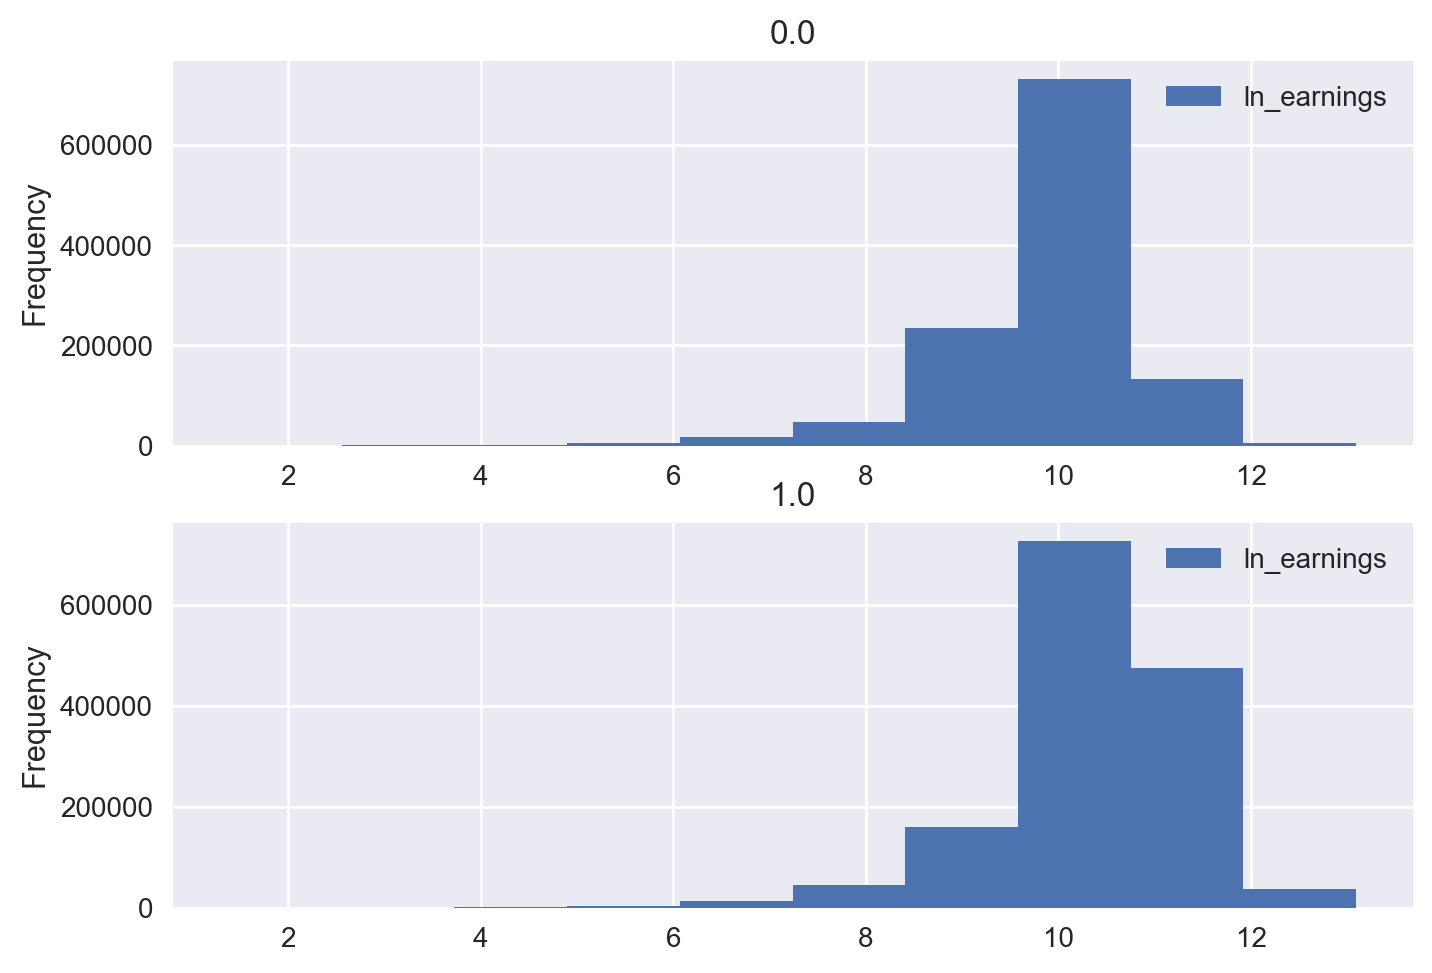

In [16]:
axes = df.plot.hist(column=["ln_earnings"], by=["college"]);

Now we can estimate the model `ln_earnings ~ college` where we cluster the standard errors at the state level:

In [17]:
fit3 = pf.feols("ln_earnings ~ college", vcov={"CRV1": "state"}, data=df)
fit3.ccv(treatment="college", pk=0.05, n_splits=2, seed=929)

,Estimate,Std. Error,t value,Pr(>|t|),2.5%,97.5%
CCV,0.4656425903701483,0.00348,133.820078,0.0,0.458657,0.472628
CRV1,0.465643,0.027142,17.155606,0.0,0.411152,0.520133


To correct for multiple testing, p-values can be adjusted via either the [Bonferroni](https://en.wikipedia.org/wiki/Bonferroni_correction) or the method by Romano and Wolf (2005), see for example [The Romano-Wolf Multiple Hypothesis
Correction in Stata](https://docs.iza.org/dp12845.pdf).

In [18]:
pf.bonferroni([fit, fit2], param="X1").round(3)

,est0,est1
Estimate,-1.019,-1.000
Std. Error,0.125,0.117
t value,-8.179,-8.568
Pr(>|t|),0.000,0.000
2.5%,-1.281,-1.245
97.5%,-0.757,-0.755
Bonferroni Pr(>|t|),0.000,0.000


In [19]:
pf.rwolf([fit, fit2], param="X1", B=9999, seed=1234).round(3)

,est0,est1
Estimate,-1.019,-1.000
Std. Error,0.125,0.117
t value,-8.179,-8.568
Pr(>|t|),0.000,0.000
2.5%,-1.281,-1.245
97.5%,-0.757,-0.755
RW Pr(>|t|),0.308,0.308


## Instrumental Variables (IV) Estimation 

It is also possible to estimate [instrumental variable models](https://en.wikipedia.org/wiki/Instrumental_variables_estimation) with *one* endogenous variable and (potentially multiple) instruments:

In [20]:
iv_fit = pf.feols(fml="Y2 ~ 1 | f1 + f2 | X1 ~ Z1 + Z2", data=data)
iv_fit.summary()

###

Estimation:  IV
Dep. var.: Y2, Fixed effects: f1+f2
Inference:  CRV1
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |     -1.600 |        0.333 |    -4.801 |      0.000 | -2.282 |  -0.919 |
---



If the model does not contain any fixed effects, just drop the second part of the formula above:

In [21]:
pf.feols(fml="Y ~ 1 | X1 ~ Z1 + Z2", data=data).summary()

###

Estimation:  IV
Dep. var.: Y, Fixed effects: 
Inference:  iid
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      0.911 |        0.156 |     5.843 |      0.000 |  0.605 |   1.217 |
| X1            |     -0.993 |        0.134 |    -7.398 |      0.000 | -1.256 |  -0.730 |
---



IV estimation with multiple endogenous variables and multiple estimation syntax is currently not supported. The syntax is `depvar ~ exog.vars | fixef effects | endog.vars ~ instruments`.

## Poisson Regression 

It is possible to estimate Poisson Regressions. We can showcase this feature with another synthetic data set.

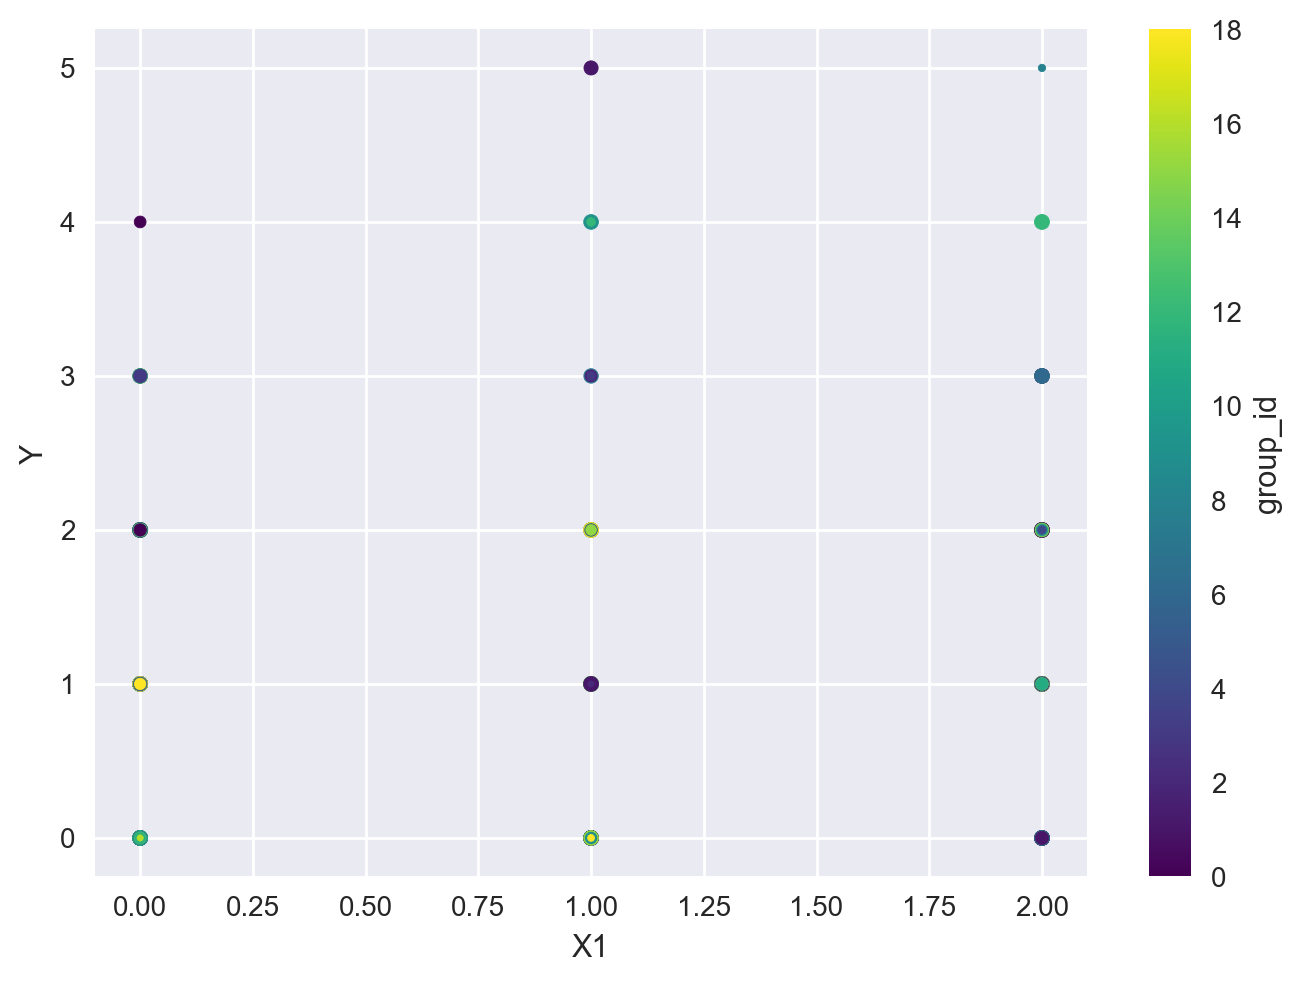

In [22]:
pois_data = pf.get_data(model="Fepois")

ax = pois_data.plot(
    kind="scatter",
    x="X1",
    y="Y",
    c="group_id",
    colormap="viridis",
    s="f2",
)

In [23]:
pois_fit = pf.fepois(fml="Y ~ X1 | group_id", data=pois_data, vcov={"CRV1": "group_id"})
pois_fit.summary()

###

Estimation:  Poisson
Dep. var.: Y, Fixed effects: group_id
Inference:  CRV1
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |      0.004 |        0.032 |     0.119 |      0.905 | -0.060 |   0.067 |
---
Deviance: 1126.202 


## Multiple Estimation 

`PyFixest` supports a range of multiple estimation functionality: `sw`, `sw0`, `csw`, `csw0`, and multiple dependent variables. If multiple regression syntax is used, 
`feols()` and `fepois` returns an instance of a `FixestMulti` object, which essentially consists of a dicionary of `Fepois` or [Feols](/reference/Feols.qmd) instances.

In [24]:
multi_fit = pf.feols(fml="Y ~ X1 | csw0(f1, f2)", data=data, vcov="HC1")
multi_fit

In [25]:
multi_fit.summary()

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: 
Inference:  HC1
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      0.919 |        0.112 |     8.223 |      0.000 |  0.699 |   1.138 |
| X1            |     -1.000 |        0.082 |   -12.134 |      0.000 | -1.162 |  -0.838 |
---
RMSE: 2.158 R2: 0.123 
###

Estimation:  OLS
Dep. var.: Y, Fixed effects: f1
Inference:  HC1
Observations:  997

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |     -0.949 |        0.066 |   -14.311 |      0.000 | -1.080 |  -0.819 |
---
RMSE: 1.73 R2: 0.437 R2 Within: 0.161 
###

Estimation:  OLS
Dep. var.: Y, Fixed effects: f1+f2
Inference:  HC1
Observations:  997

| Coefficient   |   Estimate 

Alternatively, you can look at the estimation results via the `etable()` method:

In [26]:
multi_fit.etable()

                           est1               est2               est3
------------  -----------------  -----------------  -----------------
depvar                        Y                  Y                  Y
---------------------------------------------------------------------
Intercept      0.919*** (0.112)
X1            -1.000*** (0.082)  -0.949*** (0.066)  -0.919*** (0.058)
---------------------------------------------------------------------
f2                            -                  -                  x
f1                            -                  x                  x
---------------------------------------------------------------------
R2                        0.123              0.437              0.609
S.E. type                hetero             hetero             hetero
Observations                998                997                997
---------------------------------------------------------------------
Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.00

You can access an individual model by its name - i.e. a formula - via the `all_fitted_models` attribute.

In [27]:
multi_fit.all_fitted_models["Y~X1"].tidy()

,Estimate,Std. Error,t value,Pr(>|t|),2.5%,97.5%
Coefficient,,,,,,
Intercept,0.918518,0.111707,8.222580,6.661338e-16,0.699310,1.137725
X1,-1.000086,0.082420,-12.134086,0.000000e+00,-1.161822,-0.838350


or equivalently via the `fetch_model` method:

In [28]:
multi_fit.fetch_model(0).tidy()

Model:  Y~X1


,Estimate,Std. Error,t value,Pr(>|t|),2.5%,97.5%
Coefficient,,,,,,
Intercept,0.918518,0.111707,8.222580,6.661338e-16,0.699310,1.137725
X1,-1.000086,0.082420,-12.134086,0.000000e+00,-1.161822,-0.838350


Here, `0` simply fetches the first model stored in the `all_fitted_models` dictionary, `1` the second etc.

Objects of type `Fixest` come with a range of additional methods: `tidy()`, `coef()`, `vcov()` etc, which 
essentially loop over the equivalent methods of all fitted models. E.g. `Fixest.vcov()` updates inference for all 
models stored in `Fixest`.

In [29]:
multi_fit.vcov("iid").summary()

###

Estimation:  OLS
Dep. var.: Y, Fixed effects: 
Inference:  iid
Observations:  998

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| Intercept     |      0.919 |        0.112 |     8.214 |      0.000 |  0.699 |   1.138 |
| X1            |     -1.000 |        0.085 |   -11.802 |      0.000 | -1.166 |  -0.834 |
---
RMSE: 2.158 R2: 0.123 
###

Estimation:  OLS
Dep. var.: Y, Fixed effects: f1
Inference:  iid
Observations:  997

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| X1            |     -0.949 |        0.069 |   -13.846 |      0.000 | -1.084 |  -0.815 |
---
RMSE: 1.73 R2: 0.437 R2 Within: 0.161 
###

Estimation:  OLS
Dep. var.: Y, Fixed effects: f1+f2
Inference:  iid
Observations:  997

| Coefficient   |   Estimate 

If you have estimated multiple models without multiple estimation syntax and still want to compare them, you can use the `etable()` function: 

In [30]:
pf.etable([fit, fit2])

                           est1               est2
------------  -----------------  -----------------
depvar                        Y                  Y
--------------------------------------------------
X1            -1.019*** (0.125)  -1.000*** (0.117)
Intercept                         0.919*** (0.121)
--------------------------------------------------
group_id                      x                  -
--------------------------------------------------
R2                        0.137              0.123
S.E. type          by: group_id       by: group_id
Observations                998                998
--------------------------------------------------
Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001
Format of coefficient cell:
Coefficient (Std. Error)


## Visualization 

`PyFixest` provides two functions to visualize the results of a regression: `coefplot` and `iplot`.

In [31]:
multi_fit.coefplot().show()

You can use a `matplotlib` backend as well (**tip** make sure to specify the `figsize` as the `LetsPlot` defaults are very large):

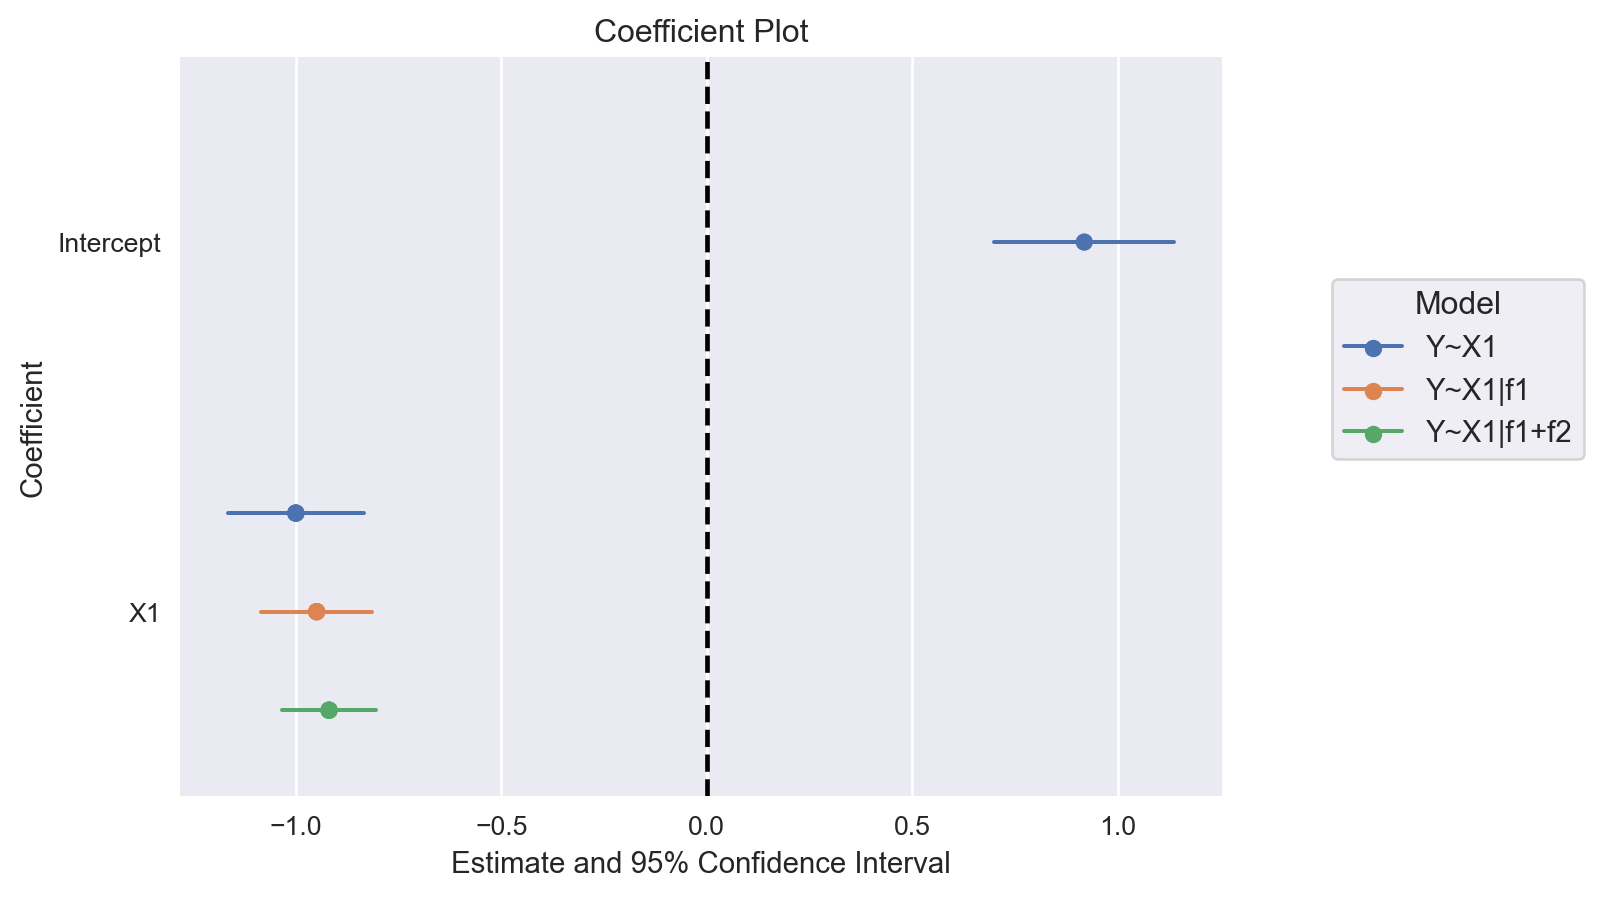

In [32]:
multi_fit.coefplot(plot_backend="matplotlib", figsize=(7, 5))

## Difference-in-Differences / Event Study Designs

`PyFixest` supports eventy study designs via two-way fixed effects and Gardner's 2-stage estimator. 

In [33]:
url = "https://raw.githubusercontent.com/s3alfisc/pyfixest/master/pyfixest/did/data/df_het.csv"
df_het = pd.read_csv(url)

df_het.head()

,unit,state,group,unit_fe,g,year,year_fe,treat,rel_year,rel_year_binned,error,te,te_dynamic,dep_var
0,1,33,Group 2,7.043016,2010,1990,0.066159,False,-20.0,-6,-0.086466,0,0.0,7.022709
1,1,33,Group 2,7.043016,2010,1991,-0.030980,False,-19.0,-6,0.766593,0,0.0,7.778628
2,1,33,Group 2,7.043016,2010,1992,-0.119607,False,-18.0,-6,1.512968,0,0.0,8.436377
3,1,33,Group 2,7.043016,2010,1993,0.126321,False,-17.0,-6,0.021870,0,0.0,7.191207
4,1,33,Group 2,7.043016,2010,1994,-0.106921,False,-16.0,-6,-0.017603,0,0.0,6.918492


In [34]:
fit_did2s = did2s(
    df_het,
    yname="dep_var",
    first_stage="~ 0 | state + year",
    second_stage="~i(rel_year,ref= -1.0)",
    treatment="treat",
    cluster="state",
)

fit_twfe = pf.feols(
    "dep_var ~ i(rel_year,ref = -1.0) | state + year",
    df_het,
    vcov={"CRV1": "state"},
)

pf.iplot(
    [fit_did2s, fit_twfe], coord_flip=False, figsize=(900, 400), title="TWFE vs DID2S"
)

The `event_study()` function provides a common API for several event study estimators.

In [35]:
fit_twfe = event_study(
    data=df_het,
    yname="dep_var",
    idname="state",
    tname="year",
    gname="g",
    estimator="twfe",
)

fit_did2s = event_study(
    data=df_het,
    yname="dep_var",
    idname="state",
    tname="year",
    gname="g",
    estimator="did2s",
)

pf.etable([fit_twfe, fit_did2s])

                          est1              est2
------------  ----------------  ----------------
depvar                 dep_var       dep_var_hat
------------------------------------------------
ATT           2.135*** (0.044)  2.152*** (0.048)
------------------------------------------------
state                        x                 -
year                         x                 -
------------------------------------------------
R2                       0.758             0.338
S.E. type            by: state              CRV1
Observations             46500             46500
------------------------------------------------
Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001
Format of coefficient cell:
Coefficient (Std. Error)


For more details see the vignette on [Difference-in-Differences Estimation](https://s3alfisc.github.io/pyfixest/difference-in-differences.html).